Frame enumuration and submission to Hyp3 with Tropo, Iono, SET corrections.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from s1_frame_enumerator import (get_s1_stack, 
                                 filter_s1_stack_by_geometric_coverage_per_pass, 
                                 get_global_s1_frames, 
                                 get_overlapping_s1_frames, 
                                 enumerate_dates, 
                                 frames2gdf, 
                                 enumerate_gunw_time_series)
from shapely.geometry import Point
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import warnings
import json
import pandas as pd
import datetime

In [3]:
AOI_NAME = 'Los-Angeles-1' #'Los Angeles' # 'Hawaii'
WEATHER_MODEL = 'HRRR'

In [4]:
if WEATHER_MODEL == 'HRRR':
    assert AOI_NAME in ['Maine', 'Bellingham', 'Los-Angeles-0', 
                        'Los-Angeles-1', 'Norfolk', 'Wax-Lake', 'Anchorage',
                        'New-York']

In [5]:
GEO_DICT = {'Los-Angeles-0':  Point(-118, 34).buffer(1),
            'Los-Angeles-1':  Point(-118, 34).buffer(1),
            'Hawaii-0': Point(-155.5, 19.5).buffer(1),
            'Hawaii-1': Point(-155.5, 19.5).buffer(1),
            'Norfolk': Point(-76.5, 36.4).buffer(1),
            'Somalia': Point(41, 1.5).buffer(1),
            'Tibet': Point(92, 41.5).buffer(1),
            'Norway': Point(13, 65).buffer(1),
            'Aleutian': Point(-177, 52).buffer(.25),
            'Wax-Lake': Point(-91.5, 30).buffer(1),
            'Bellingham': Point(-122.5, 48.5).buffer(1),
            'Maine': Point(-69, 47).buffer(1),
            'Anchorage': Point(-150, 61).buffer(1),
            'Chile': Point(-69.0355, -19.449).buffer(2.5),
            'Saudi-Arabia': Point(47.5, 24).buffer(2.5),
            'New-York': Point(-74, 42).buffer(2),
            'Chile-South': Point(-70.5, -54.5).buffer(1)
            }

TRACK_DICT = {'Los-Angeles-0': [64],
              'Los-Angeles-1': [71],
              'Hawaii-0': [124],
              'Hawaii-1': [87],
              'Norfolk': [4],
              'Somalia': [87],
              'Tibet': [48],
              'Norway': [37],
              'Aleutian': [59],
              'Wax-Lake': [63],
              'Bellingham': [137],
              'Maine': [164],
              'Anchorage': [131],
              'Chile': [54],
              'Saudi-Arabia': [72],
              'New-York': [33],
              'Chile-South': [33],
              }

In [6]:
aoi_geo = GEO_DICT[AOI_NAME]
track_numbers = TRACK_DICT[AOI_NAME]

df_aoi = gpd.GeoDataFrame(geometry=[aoi_geo], crs=CRS.from_epsg(4326))

In [7]:
frames = get_overlapping_s1_frames(aoi_geo, track_numbers=track_numbers)

In [8]:
# There will be lots of ways to do this more efficiently i.e. only include frames with overlap of a land mask
# Even to be more confident would likely want some percentage
# Currently, we just shrunk our AOI and excluded a frame
if AOI_NAME == 'Aleutian':
    frames = list(filter(lambda f: f.frame_id!= 9101, frames))

In [9]:
df_frames_all = frames2gdf(frames)
df_frames_all.head()

,frame_id,hemisphere,track_number_min,track_number_max,geometry
0,11041,west,71,71,"POLYGON Z ((-119.16665 33.92554 0, -119.00067 ..."
1,11042,west,71,71,"POLYGON Z ((-119.39578 32.76396 0, -119.26382 ..."


<Axes: >

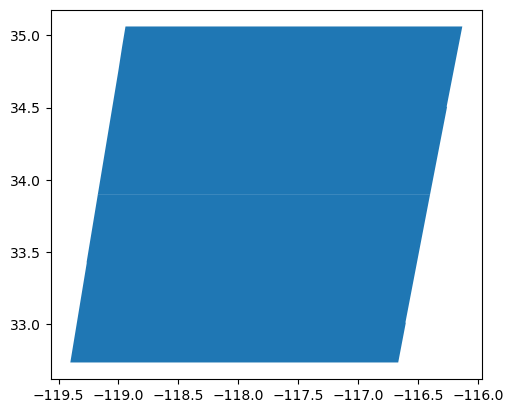

In [10]:
df_frames_all.plot()

(31.735062874632497, 36.06211520378212)

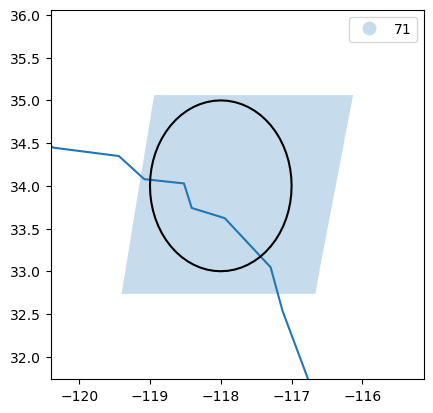

In [11]:
fig, ax = plt.subplots()

url = 'https://github.com/nvkelso/natural-earth-vector/raw/refs/heads/master/110m_physical/ne_110m_land.shp'

df_world = gpd.read_file(url)
df_world.boundary.plot(ax=ax)
df_frames_by_track = df_frames_all.dissolve(by='track_number_min').reset_index(drop=False)
df_frames_by_track.plot(ax=ax, 
                        column='track_number_min',
                        categorical=True,
                        alpha=.25, 
                        legend=True)
df_aoi.boundary.plot(ax=ax, edgecolor='black')
xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

(31.735062874632497, 36.06211520378212)

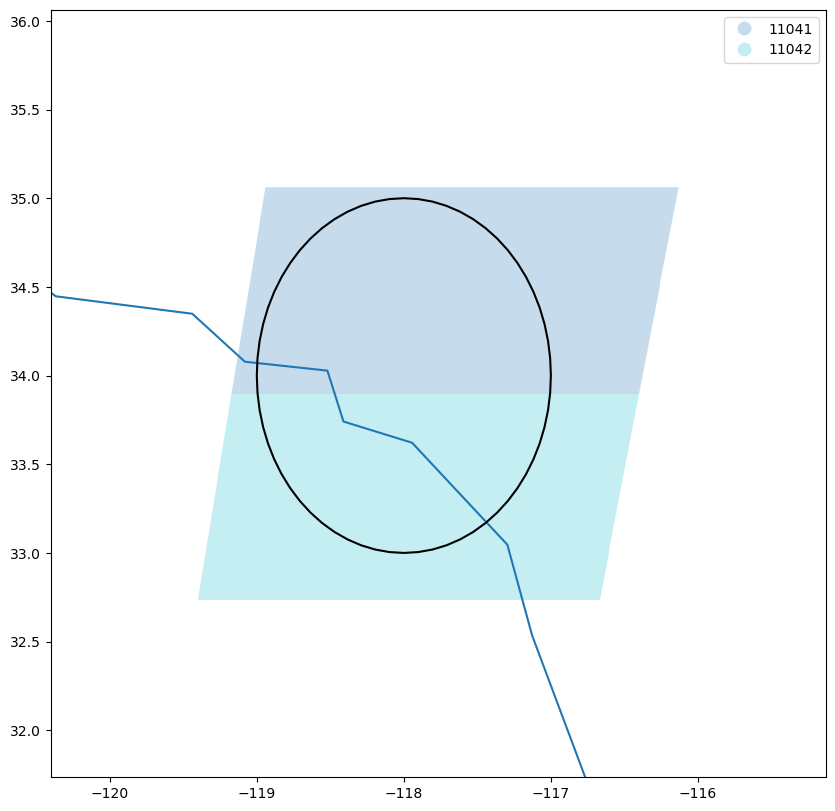

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
df_world.boundary.plot(ax=ax)
df_frames_all.plot(ax=ax, 
                   column='frame_id', 
                   alpha=.25,
                   categorical=True,
                   legend=True)
df_aoi.boundary.plot(ax=ax, edgecolor='black')

xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

# Get Stack from Frame

Here a stack is a list of images with metadata and extents. We note the stack here is not arbitrarily constructed and at some point might be nice to create a simple class to encapsulate it. However, here a stack is one that can be organized to do interferometry over the frames.

1. Per pass coverage $\geq 80$% as it pertains to the frame's coverage geometry
2. Contiguous coverage through frames (determined as Polygon object)

Requires:

1. Frames to be contiguous (otherwise 2. does not make sense)
2. Requires single track or two sequential tracks (we only check if the track numbers are sequential)

In [13]:
df_stack = get_s1_stack(frames)
df_stack.head()

["'type': 'EXTRA_DIMENSION': 'report': Only 2-Dimensional area of interests are supported (lon/lat), higher dimension coordinates will be ignored", "'type': 'GEOMETRY_SIMPLIFICATION': 'report': 'Shape Simplified: shape of 9 simplified to 8 with proximity threshold of 0.0004'", "'type': 'REVERSE': 'report': Reversed polygon winding order"]
["'type': 'EXTRA_DIMENSION': 'report': Only 2-Dimensional area of interests are supported (lon/lat), higher dimension coordinates will be ignored", "'type': 'GEOMETRY_SIMPLIFICATION': 'report': 'Shape Simplified: shape of 9 simplified to 8 with proximity threshold of 0.0004'", "'type': 'REVERSE': 'report': Reversed polygon winding order"]
/Users/cmarshak/miniforge3/envs/aria_hyp3_env/lib/python3.13/site-packages/s1_frame_enumerator/s1_stack_formatter.py:60: FutureWarning: DataFrameGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  df_formatted['stack_repeat_pass_id'] = df_formatted.groupby(['stack_repeat_pass_id']).grou

,slc_id,start_time,stop_time,url,track_number,polarization,orbit,beam_mode,size_gb,stack_repeat_pass_id,repeat_pass_timestamp,geometry
0,S1A_IW_SLC__1SSV_20150514T135131_20150514T1351...,2015-05-14 13:51:31+00:00,2015-05-14 13:51:58+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,71,VV,5918,IW,2.441383,7,2015-05-14 00:00:00+00:00,"POLYGON ((-116.29264 34.41975, -115.90839 36.0..."
1,S1A_IW_SLC__1SSV_20150514T135156_20150514T1352...,2015-05-14 13:51:56+00:00,2015-05-14 13:52:23+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,71,VV,5918,IW,2.373122,8,2015-05-14 00:00:00+00:00,"POLYGON ((-116.63796 32.92426, -116.26044 34.5..."
2,S1A_IW_SLC__1SSV_20150514T135221_20150514T1352...,2015-05-14 13:52:21+00:00,2015-05-14 13:52:38+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,71,VV,5918,IW,1.263729,8,2015-05-14 00:00:00+00:00,"POLYGON ((-116.8303 32.03358, -116.59662 33.05..."
3,S1A_IW_SLC__1SSV_20150607T135133_20150607T1352...,2015-06-07 13:51:33+00:00,2015-06-07 13:52:00+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,71,VV,6268,IW,2.439814,10,2015-06-07 00:00:00+00:00,"POLYGON ((-116.2917 34.41921, -115.90733 36.04..."
4,S1A_IW_SLC__1SSV_20150607T135158_20150607T1352...,2015-06-07 13:51:58+00:00,2015-06-07 13:52:25+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,71,VV,6268,IW,2.354046,10,2015-06-07 00:00:00+00:00,"POLYGON ((-116.63698 32.92408, -116.25948 34.5..."


# Select N Dates from stack

To make sure there is weather model availability, we are going to truncate the stack to dates on or before `2022-03-01`.

In [14]:
if AOI_NAME == 'Tibet':
    N = 5
else:
    N = 3

# Give ourselves 1 year buffer
MIN_DATE = pd.Timestamp('2025-03-01', tz='UTC')
df_stack_f = df_stack[df_stack.repeat_pass_timestamp >= MIN_DATE]

dates = sorted(df_stack_f.repeat_pass_timestamp.unique(), reverse=True)
df_stack_f = df_stack_f[df_stack_f.repeat_pass_timestamp >= dates[N]].reset_index(drop=True)
df_stack_f.head()

,slc_id,start_time,stop_time,url,track_number,polarization,orbit,beam_mode,size_gb,stack_repeat_pass_id,repeat_pass_timestamp,geometry
0,S1C_IW_SLC__1SDV_20250831T135108_20250831T1351...,2025-08-31 13:51:08+00:00,2025-08-31 13:51:35+00:00,https://datapool.asf.alaska.edu/SLC/SC/S1C_IW_...,71,VV+VH,3917,IW,4.363307,420,2025-08-31 00:00:00+00:00,"POLYGON ((-115.90147 36.10034, -118.66818 36.4..."
1,S1C_IW_SLC__1SDV_20250831T135133_20250831T1352...,2025-08-31 13:51:33+00:00,2025-08-31 13:52:00+00:00,https://datapool.asf.alaska.edu/SLC/SC/S1C_IW_...,71,VV+VH,3917,IW,4.272327,420,2025-08-31 00:00:00+00:00,"POLYGON ((-116.23997 34.6039, -118.95996 35.00..."
2,S1C_IW_SLC__1SDV_20250831T135158_20250831T1352...,2025-08-31 13:51:58+00:00,2025-08-31 13:52:24+00:00,https://datapool.asf.alaska.edu/SLC/SC/S1C_IW_...,71,VV+VH,3917,IW,3.476111,420,2025-08-31 00:00:00+00:00,"POLYGON ((-116.58599 33.10832, -119.25732 33.5..."
3,S1A_IW_SLC__1SDV_20250906T135216_20250906T1352...,2025-09-06 13:52:16+00:00,2025-09-06 13:52:43+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,71,VV+VH,60868,IW,4.369548,421,2025-09-06 00:00:00+00:00,"POLYGON ((-115.9431 35.87596, -118.7299 36.275..."
4,S1A_IW_SLC__1SDV_20250906T135240_20250906T1353...,2025-09-06 13:52:40+00:00,2025-09-06 13:53:07+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,71,VV+VH,60868,IW,4.254568,421,2025-09-06 00:00:00+00:00,"POLYGON ((-116.27678 34.37864, -119.01865 34.7..."


# Generate Pairs

In [15]:
min_temporal_baseline = 0
neighbors = 2

data = enumerate_gunw_time_series(df_stack_f, 
                                  min_temporal_baseline, 
                                  n_secondary_scenes_per_ref=neighbors,
                                  frames=frames 
                                 )

Date Pairs: 100%|█| 5/5 [00:00<00:00, 179.00it/s


In [16]:
len(data)

10

In [17]:
data[0]

{'reference': ['S1A_IW_SLC__1SDV_20250918T135224_20250918T135251_061043_079B66_3780',
  'S1A_IW_SLC__1SDV_20250918T135249_20250918T135316_061043_079B66_3687'],
 'secondary': ['S1C_IW_SLC__1SDV_20250912T135109_20250912T135136_004092_008227_1174',
  'S1C_IW_SLC__1SDV_20250912T135134_20250912T135201_004092_008227_24D9'],
 'reference_date': Timestamp('2025-09-18 00:00:00+0000', tz='UTC'),
 'secondary_date': Timestamp('2025-09-12 00:00:00+0000', tz='UTC'),
 'frame_id': 11041,
 'geometry': <POLYGON Z ((-119.167 33.926 0, -119.001 34.755 0, -118.97 34.921 0, -118.94...>}

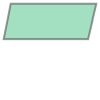

In [18]:
data[0]['geometry']

In [19]:
data

[{'reference': ['S1A_IW_SLC__1SDV_20250918T135224_20250918T135251_061043_079B66_3780',
   'S1A_IW_SLC__1SDV_20250918T135249_20250918T135316_061043_079B66_3687'],
  'secondary': ['S1C_IW_SLC__1SDV_20250912T135109_20250912T135136_004092_008227_1174',
   'S1C_IW_SLC__1SDV_20250912T135134_20250912T135201_004092_008227_24D9'],
  'reference_date': Timestamp('2025-09-18 00:00:00+0000', tz='UTC'),
  'secondary_date': Timestamp('2025-09-12 00:00:00+0000', tz='UTC'),
  'frame_id': 11041,
  'geometry': <POLYGON Z ((-119.167 33.926 0, -119.001 34.755 0, -118.97 34.921 0, -118.94...>},
 {'reference': ['S1A_IW_SLC__1SDV_20250918T135224_20250918T135251_061043_079B66_3780',
   'S1A_IW_SLC__1SDV_20250918T135249_20250918T135316_061043_079B66_3687'],
  'secondary': ['S1C_IW_SLC__1SDV_20250912T135134_20250912T135201_004092_008227_24D9',
   'S1C_IW_SLC__1SDV_20250912T135159_20250912T135225_004092_008227_AE56'],
  'reference_date': Timestamp('2025-09-18 00:00:00+0000', tz='UTC'),
  'secondary_date': Timesta

# Hyp3

In [20]:
TRACKS = ",".join([str(t) for t in TRACK_DICT[AOI_NAME]])
TODAY = datetime.datetime.now().date().strftime('%m%d')
AOI_TOKEN = AOI_NAME.replace(' ', '-')
TOKENS = [t for t in [AOI_TOKEN, TRACKS, WEATHER_MODEL, TODAY] if t]
JOB_NAME = '_'.join(TOKENS)
f'JOB_NAME: {JOB_NAME}'

'JOB_NAME: Los-Angeles-1_71_HRRR_0922'

In [21]:
f'JOB_NAME character length: {len(JOB_NAME)}'

'JOB_NAME character length: 26'

In [22]:
assert len(JOB_NAME) <= 30

In [23]:
job_parameters =  [{'granules': ifg_data['reference'],
                    'secondary_granules': ifg_data['secondary'],
                   'weather_model': WEATHER_MODEL,
                    'frame_id': ifg_data['frame_id'],
                     } for ifg_data in data]
[params.pop('weather_model') for params in job_parameters if params['weather_model'] is None]
job_parameters[:2]

[{'granules': ['S1A_IW_SLC__1SDV_20250918T135224_20250918T135251_061043_079B66_3780',
   'S1A_IW_SLC__1SDV_20250918T135249_20250918T135316_061043_079B66_3687'],
  'secondary_granules': ['S1C_IW_SLC__1SDV_20250912T135109_20250912T135136_004092_008227_1174',
   'S1C_IW_SLC__1SDV_20250912T135134_20250912T135201_004092_008227_24D9'],
  'weather_model': 'HRRR',
  'frame_id': 11041},
 {'granules': ['S1A_IW_SLC__1SDV_20250918T135224_20250918T135251_061043_079B66_3780',
   'S1A_IW_SLC__1SDV_20250918T135249_20250918T135316_061043_079B66_3687'],
  'secondary_granules': ['S1C_IW_SLC__1SDV_20250912T135134_20250912T135201_004092_008227_24D9',
   'S1C_IW_SLC__1SDV_20250912T135159_20250912T135225_004092_008227_AE56'],
  'weather_model': 'HRRR',
  'frame_id': 11042}]

In [24]:
job_dicts = [{'name': JOB_NAME,
              # NOTE: we are still using the `dev` branch. Change this to "INSAR_ISCE" to use the `main` branch.
              'job_type': 'INSAR_ISCE',
              'job_parameters': parameters
             }
             for parameters in job_parameters]
job_dicts[:2]

[{'name': 'Los-Angeles-1_71_HRRR_0922',
  'job_type': 'INSAR_ISCE',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20250918T135224_20250918T135251_061043_079B66_3780',
    'S1A_IW_SLC__1SDV_20250918T135249_20250918T135316_061043_079B66_3687'],
   'secondary_granules': ['S1C_IW_SLC__1SDV_20250912T135109_20250912T135136_004092_008227_1174',
    'S1C_IW_SLC__1SDV_20250912T135134_20250912T135201_004092_008227_24D9'],
   'weather_model': 'HRRR',
   'frame_id': 11041}},
 {'name': 'Los-Angeles-1_71_HRRR_0922',
  'job_type': 'INSAR_ISCE',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20250918T135224_20250918T135251_061043_079B66_3780',
    'S1A_IW_SLC__1SDV_20250918T135249_20250918T135316_061043_079B66_3687'],
   'secondary_granules': ['S1C_IW_SLC__1SDV_20250912T135134_20250912T135201_004092_008227_24D9',
    'S1C_IW_SLC__1SDV_20250912T135159_20250912T135225_004092_008227_AE56'],
   'weather_model': 'HRRR',
   'frame_id': 11042}}]

In [28]:
job_dicts

[{'name': 'Los-Angeles-1_71_HRRR_0922',
  'job_type': 'INSAR_ISCE',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20250918T135224_20250918T135251_061043_079B66_3780',
    'S1A_IW_SLC__1SDV_20250918T135249_20250918T135316_061043_079B66_3687'],
   'secondary_granules': ['S1C_IW_SLC__1SDV_20250912T135109_20250912T135136_004092_008227_1174',
    'S1C_IW_SLC__1SDV_20250912T135134_20250912T135201_004092_008227_24D9'],
   'weather_model': 'HRRR',
   'frame_id': 11041}},
 {'name': 'Los-Angeles-1_71_HRRR_0922',
  'job_type': 'INSAR_ISCE',
  'job_parameters': {'granules': ['S1A_IW_SLC__1SDV_20250918T135224_20250918T135251_061043_079B66_3780',
    'S1A_IW_SLC__1SDV_20250918T135249_20250918T135316_061043_079B66_3687'],
   'secondary_granules': ['S1C_IW_SLC__1SDV_20250912T135134_20250912T135201_004092_008227_24D9',
    'S1C_IW_SLC__1SDV_20250912T135159_20250912T135225_004092_008227_AE56'],
   'weather_model': 'HRRR',
   'frame_id': 11042}},
 {'name': 'Los-Angeles-1_71_HRRR_0922',
  'job_type'

In [25]:
len(job_dicts)

10

You may want to use `prompt=True` to toggle between Earthdata accounts.

In [26]:
import hyp3_sdk

# uses .netrc; add `prompt=True` to prompt for credentials; 
hyp3_isce = hyp3_sdk.HyP3('https://hyp3-a19-jpl-test.asf.alaska.edu')
# hyp3_isce = hyp3_sdk.HyP3('https://hyp3-tibet-jpl.asf.alaska.edu')

Uncomment this to submit jobs:

In [27]:
# submitted_jobs = hyp3_isce.submit_prepared_jobs(job_dicts[:])

These are useful snippets to inspect status and view metadata.

In [39]:
jobs = hyp3_isce.find_jobs(name=JOB_NAME)
print(jobs)

15 HyP3 Jobs: 15 succeeded, 0 failed, 0 running, 0 pending.


In [28]:
# jobs[0].to_dict()

In [29]:
# successful_jobs = hyp3_isce.find_jobs(name=JOB_NAME, status_code='SUCCEEDED')
# dicts_success = [j.to_dict() for j in successful_jobs]
# dicts_success[:]

In [30]:
# urls = [d['files'][0]['url'] for d in dicts_success]
# urls

In [31]:
# all_jobs = hyp3_isce.find_jobs(name=JOB_NAME)
# dicts_all = [j.to_dict() for j in all_jobs]
# dicts_all[:]

# Failed Jobs and Resubmission

In [32]:
failed_jobs = hyp3_isce.find_jobs(name=JOB_NAME, status_code='FAILED')
dicts_failed = [j.to_dict() for j in failed_jobs]
dicts_failed[:]

[]

In [33]:
JOB_NAME_RESUBMIT = JOB_NAME + '_v2'

In [34]:
job_dicts_resubmit = [{'name': JOB_NAME_RESUBMIT,
                       # NOTE: we are still using the `dev` branch. Change this to "INSAR_ISCE" to use the `main` branch.
                       'job_type': 'INSAR_ISCE_TEST',
                      'job_parameters': d['job_parameters']
                      }
                     for d in dicts_failed[:1]]
job_dicts_resubmit

[]

In [35]:
# submitted_jobs = hyp3_isce.submit_prepared_jobs(job_dicts_resubmit[:])

In [36]:
jobs_v2 = hyp3_isce.find_jobs(name=JOB_NAME_RESUBMIT)
print(jobs_v2)

0 HyP3 Jobs: 0 succeeded, 0 failed, 0 running, 0 pending.
